In [9]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix

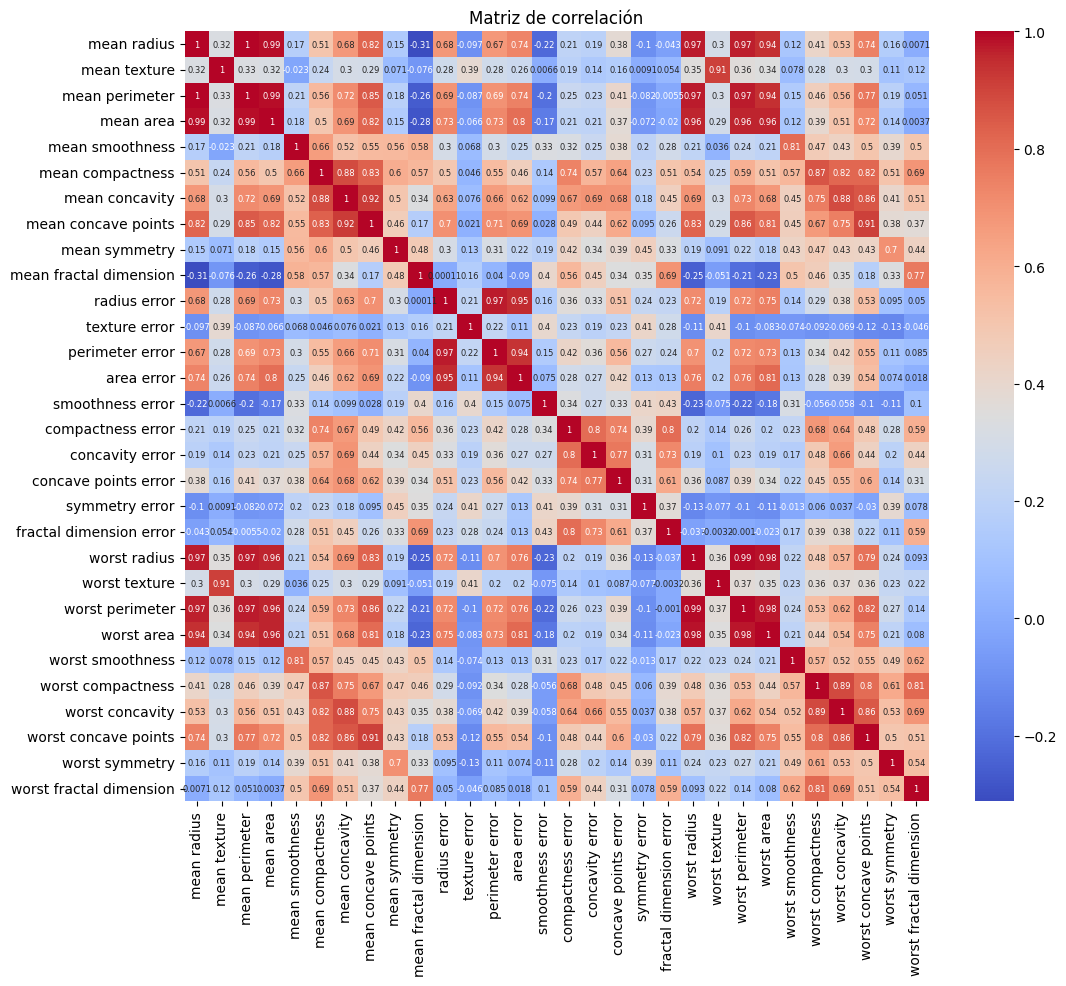

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)

# Matriz de correlación para evitar multicolinealidad
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 6})
plt.title("Matriz de correlación")
plt.show()

Variables eliminadas por alta correlación: ['mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


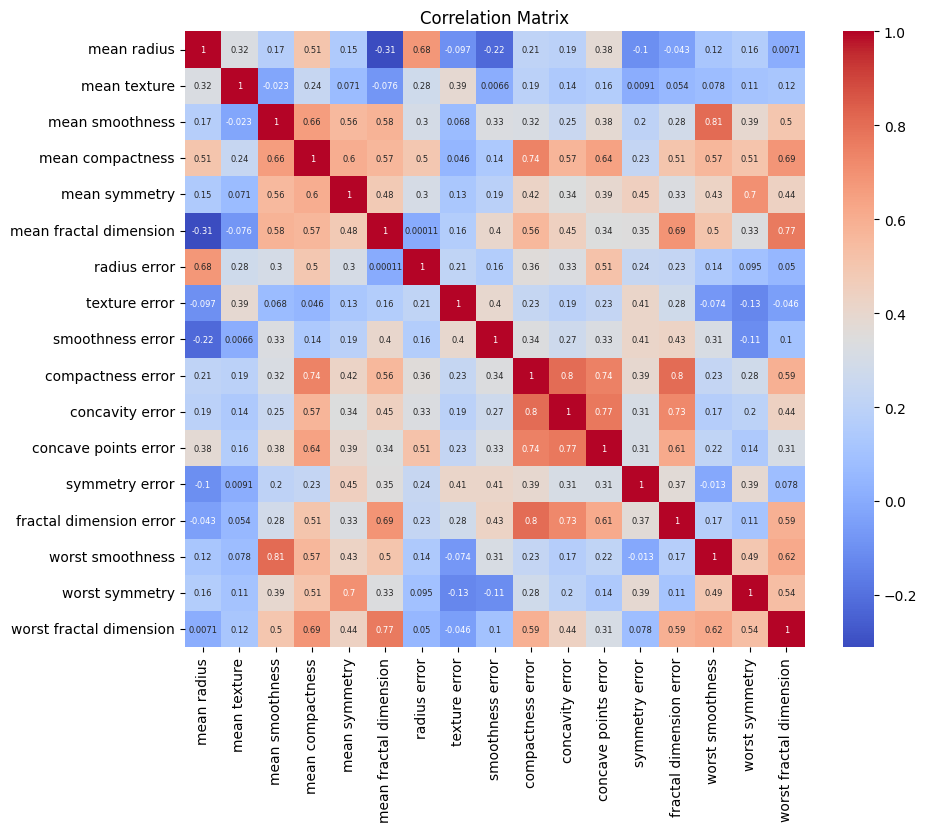

In [3]:
# Crear una lista para guardar las columnas que vamos a eliminar
to_drop = []
cor_matrix = correlation_matrix.abs()
# Revisamos cada par de columnas (sin repetir)
for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if round(cor_matrix.iloc[i, j],1) > 0.8:
            colname = cor_matrix.columns[i]
            if colname not in to_drop:
                to_drop.append(colname)

# Mostramos qué columnas se eliminarán
print("Variables eliminadas por alta correlación:", to_drop)

# Eliminamos las columnas de X
X_filtered = X.drop(columns=to_drop)

plt.figure(figsize=(10, 8))
sns.heatmap(X_filtered.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title("Correlation Matrix")
plt.show()

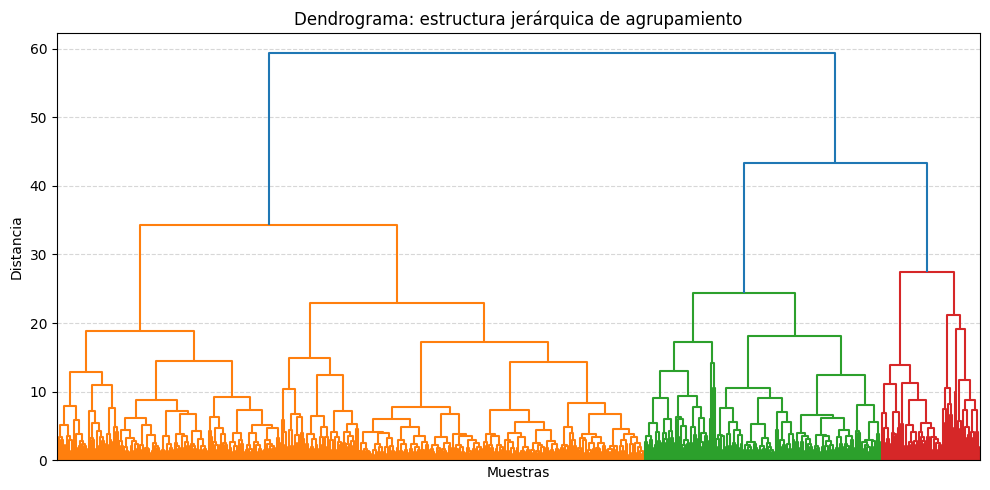

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
# Enlace jerárquico
Z = linkage(X_scaled, method='ward')

# Graficar dendrograma
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.xticks([])  # quitar números de muestra del eje X
plt.title('Dendrograma: estructura jerárquica de agrupamiento')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

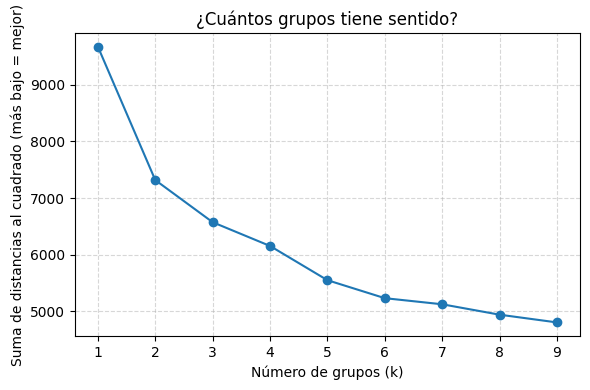

In [5]:
suma_distancias = []
valores_k = range(1, 10)

for k in valores_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    suma_distancias.append(kmeans.inertia_)  # Esta es la suma de distancias al cuadrado

# Paso 3: Graficar la curva del codo
plt.figure(figsize=(6, 4))
plt.plot(valores_k, suma_distancias, marker='o')
plt.title("¿Cuántos grupos tiene sentido?")
plt.xlabel("Número de grupos (k)")
plt.ylabel("Suma de distancias al cuadrado (más bajo = mejor)")
plt.xticks(valores_k)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## **<span style="color:#1a73e8;">CLUSTER</span>**

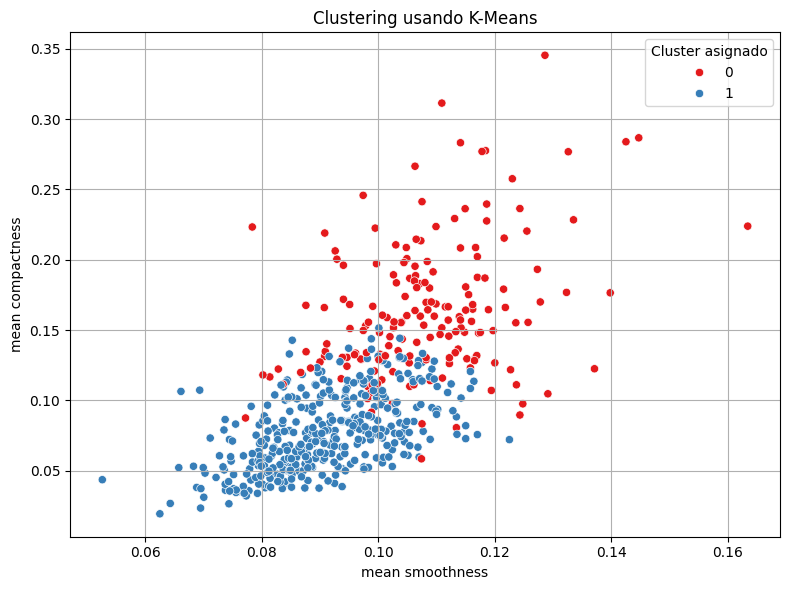

In [6]:
# 📌 Paso 1: Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# 📌 Paso 2: Aplicar K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)  # fit_predict devuelve directamente las etiquetas

# Añadimos los labels al DataFrame original (sin escalar)
X_plot = X_filtered.copy()
X_plot['cluster'] = labels

# 📌 Paso 3: Visualizar en dos variables poco correlacionadas
var1 = X_plot.columns[2]
var2 = X_plot.columns[3]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_plot,
    x=var1,
    y=var2,
    hue='cluster',
    palette='Set1'
)
plt.title("Clustering usando K-Means")
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend(title='Cluster asignado')
plt.tight_layout()
plt.grid(True)
plt.show()


Distribución de la variable real 'target' (tipo de tumor) dentro de cada clúster:
cluster  target
0        0         0.707865
         1         0.292135
1        1         0.780051
         0         0.219949
Name: proportion, dtype: float64


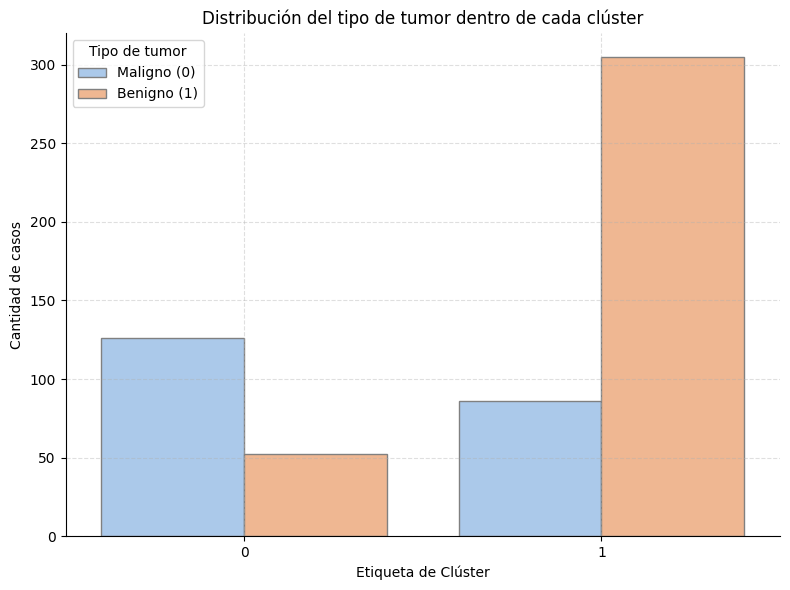

In [8]:
# 📌 Paso 1: Ver la proporción de etiquetas reales ('maligno' o 'benigno') dentro de cada clúster
# Esto nos ayuda a ver qué tan homogéneo es cada grupo.
df = X_plot.copy()
df['target'] = data.target  
cluster_stats = df.groupby('cluster')['target'].value_counts(normalize=True)

print("Distribución de la variable real 'target' (tipo de tumor) dentro de cada clúster:")
print(cluster_stats)

# 📌 Paso 2: Gráfico de barras para comparar la distribución de 'target' en cada clúster

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='cluster', hue='target', palette='pastel', edgecolor='gray')
plt.title('Distribución del tipo de tumor dentro de cada clúster')
plt.xlabel('Etiqueta de Clúster')
plt.ylabel('Cantidad de casos')
plt.legend(title='Tipo de tumor', labels=['Maligno (0)', 'Benigno (1)'])
plt.grid(True, linestyle="--", alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

Matriz de confusión:
[[126  86]
 [ 52 305]]


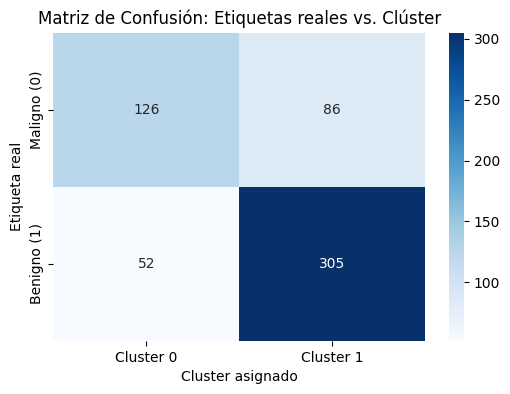

In [10]:
# Crear matriz de confusión
cm = confusion_matrix(df['target'], df['cluster'])

print("Matriz de confusión:")
print(cm)

# Graficar matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Cluster {i}" for i in sorted(df['cluster'].unique())],
            yticklabels=['Maligno (0)', 'Benigno (1)'])
plt.xlabel("Cluster asignado")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión: Etiquetas reales vs. Clúster")
plt.show()